# Movie recommender with multinomial RBM (Python, Tensorflow, GPU)

A Restricted Boltzmann Machine (RBM) is used to perform collaborative filtering over the Movielens dataset.
The RBM is a generative model, it learns the joint probability distribution $P(v,h)$, where $v$ are the visible units and $h$ the hidden ones. The hidden units are latent variables while the visible units are clamped on the input data. The model generates ratings for a user/movie pair using a collaborative filtering based approach. 

The dataset contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users. The movies are ranked from 1-5; In the first iteration of this notebook we consider a simplifie version of the problem, implementing a binary encoding of the dataset. The reason for this choice is that one can use a more traditional binary RBM instead of a multinomial one, see below for further discussion.



## 0 Global Settings and Import

In [1]:
#load libraries

from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

# set the environment path to find Recommenders
import sys
sys.path.append("../../")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import papermill as pm
from zipfile import ZipFile

from reco_utils.recommender.rbm.Mrbm_tensorflow import RBM
from reco_utils.dataset.python_splitters import python_stratified_split
from reco_utils.dataset.url_utils import maybe_download
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

#For interactive mode only
%load_ext autoreload
%autoreload 2

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

System version: 3.6.0 | packaged by conda-forge | (default, Feb  9 2017, 14:36:55) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas version: 0.23.4


# 1 Load Data 

In [2]:
# Select Movielens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '1m'

In [3]:
# MovieLens data have different data-format for each size of dataset 
data_header = None
if MOVIELENS_DATA_SIZE == '100k':
    separator = '\t'
    data_name = 'u.data'
    data_folder = 'ml-100k'
elif MOVIELENS_DATA_SIZE == '1m':
    separator = '::'
    data_name = 'ratings.dat'
    data_folder = 'ml-1m'
elif MOVIELENS_DATA_SIZE == '10m':
    separator = '::'
    data_name = 'ratings.dat'
    data_folder = 'ml-10M100K'
elif MOVIELENS_DATA_SIZE == '20m':
    separator = ','
    data_name = 'ratings.csv'
    data_folder = 'ml-20m'
    data_header = 0
else:
    raise ValueError('Invalid data size. Should be one of {100k, 1m, 10m, or 20m}') 

# Download dataset zip file and decompress if haven't done yet
data_path = os.path.join(data_folder, data_name)
if not os.path.exists(data_path):
    filename = 'ml-' + MOVIELENS_DATA_SIZE + '.zip'
    filepath = maybe_download('http://files.grouplens.org/datasets/movielens/'+filename, filename)

    with ZipFile(filepath, 'r') as zf:
        zf.extractall()
    
    # remove zip file we already used
    os.remove(filepath)
    
data = pd.read_csv(
    data_path,
    sep=separator,
    engine='python',
    names=['userID','MovieId','Rating','Timestamp'],
    header=data_header
)
data.head()

,userID,MovieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 1.2 Split the data using the stratified python splitter  

In [4]:
train, test = python_stratified_split(data)

## 2 Train the RBM model






In [10]:
header = {
        "col_user": "userID",
        "col_item": "MovieId",
        "col_rating": "Rating",
    }


model = RBM(hidden_units= 1000, keep_prob= .7, training_epoch = 10,**header)


Generating the user affinity matrix...
Creating the computational graph


training epoch 0 rmse Train 0.929868 
training epoch 10 rmse Train 0.844306 


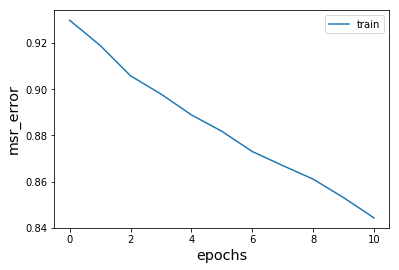

In [11]:
model.fit(train)

In [21]:
top_k = model.recommend_k_items(test, top_k = 10)

# TODO: remove this call when the model returns same type as input
top_k['userID'] = pd.to_numeric(top_k['userID'])
top_k['MovieId'] = pd.to_numeric(top_k['MovieId'])

display(top_k.head() ) 

Restoring parameters from saver/rbm_model_saver.ckpt
Formatting output


,userID,MovieId,prediction
0,1,592,4.986285
1,1,526,4.977319
2,1,16,4.975157
3,1,3409,4.974627
4,1,2632,4.974010


## 4 Evaluation metrics 

In [ ]:
eval_precision = precision_at_k(test, top_k, col_user="userID", col_item="MovieId", 
                                col_rating="Rating", col_prediction="prediction", 
                                relevancy_method="top_k", k= 10)

## 5 Recommendation report    

Once the system has been trained, we produce a recommendation report for a given user. Below we can select a user and plot the first k movies with the highest score. Note that these suggestions possibly includes movies that have already been seen by the user. We can also provide a list of reccomended but so far unseen movies

In [11]:
#Recommended Movies, possibly including seen ones 
#select a user by changing the id below. The id is an integer number from 0 to n_user

usr_id = 0
k=10

usr_mv_like = np.where(vp[usr_id,:]==2) #for each user selects the liked movies 
mv_id = (np.asanyarray(usr_mv_like)+1).flatten() 

MVI= np.in1d(movies_df['MovieID'].values, mv_id) #index of liked movies 

#add the recommendation score 
sel_movie = movies_df[MVI] 
sel_movie['reco score'] = pvh[usr_id,usr_mv_like,1].flatten()

#order the movies according to their score 
sel_movie.sort_values(['reco score'], ascending = False).head(k)

C:\Users\mimillet\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,MovieID,Title,Genre,reco score
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.738748
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.737414
0,1,Toy Story (1995),Animation|Children's|Comedy,0.737017
604,608,Fargo (1996),Crime|Drama|Thriller,0.734234
907,919,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical,0.732835
1959,2028,Saving Private Ryan (1998),Action|Drama|War,0.732750
2647,2716,Ghostbusters (1984),Comedy|Horror,0.732745
2559,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.732674
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,0.732558
2693,2762,"Sixth Sense, The (1999)",Thriller,0.732054


In [12]:
#Recommended, unseen Movies 
#select a user by changing the id below. The id is an integer number from 0 to n_user

mv_unseen = np.where(RX[usr_id]==0) 
mv_id_un= np.intersect1d(usr_mv_like, mv_unseen)
mv_id_unseen = mv_id_un+1 

MVI_unseen= np.in1d(movies_df['MovieID'].values, mv_id_unseen)

sel_unseen_movie = movies_df[MVI_unseen]

sel_unseen_movie['reco score'] = pvh[usr_id,mv_id_un,1].flatten()

sel_unseen_movie.sort_values(['reco score'], ascending = False).head(10)

C:\Users\mimillet\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,MovieID,Title,Genre,reco score
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.738748
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.737414
2647,2716,Ghostbusters (1984),Comedy|Horror,0.732745
2559,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.732674
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,0.732558
642,648,Mission: Impossible (1996),Action|Adventure|Mystery,0.731406
1203,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama,0.731205
453,457,"Fugitive, The (1993)",Action|Thriller,0.731133
1271,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure,0.730507
1245,1265,Groundhog Day (1993),Comedy|Romance,0.730242


We can check if this result makes sense by looking at the orginal movies rated by user 1. There is a good mixture of Action/Sci-Fi, Comedy and drama, even though there is no much children's movie. For example, the user watched Star wars episode IV and the model suggest to watch episode VI. If you wonder why there is no episode V that is a good question! Personally, my favourites of the old series are IV and VI, as it seems to be the case for many people, so it may not be totally unreasonable.  

In [13]:
merged_df = pd.merge(movies_df, ratings_df[['UserID', 'MovieID','Rating']], on='MovieID')
merged_df[ merged_df['UserID'] ==1 ]

,MovieID,Title,Genre,UserID,Rating
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5
22893,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5
41541,150,Apollo 13 (1995),Drama,1,5
67447,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4
141660,527,Schindler's List (1993),Drama|War,1,5
144754,531,"Secret Garden, The (1993)",Children's|Drama,1,4
158459,588,Aladdin (1992),Animation|Children's|Comedy|Musical,1,4
167921,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical,1,4
168684,595,Beauty and the Beast (1991),Animation|Children's|Musical,1,5
172011,608,Fargo (1996),Crime|Drama|Thriller,1,4


The analysis of the multinomial case will be presented later